# Cluster Analysis of E-Commerce Dataset

## Introduction

Business team want to create "Lolayty Customer" campaign by giving voucher based on certain condition. But, of course, we don't want to give vouchers sporadically. Then they want you to check which users that will be injected by voucher based on their loyalty to your platform.

# Install and Load Packages

In [1]:
!pip install yellowbrick

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.spatial import ConvexHull

from datetime import datetime

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer

# Load Dataset

In [3]:
raw_data = pd.read_csv("https://raw.githubusercontent.com/hadimaster65555/dataset_for_teaching/main/dataset/ecommerce/data.csv", encoding = "latin-1")

# RFM Analysis

## Data Preprocessing

Check `raw_data` structure

In [4]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [5]:
raw_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


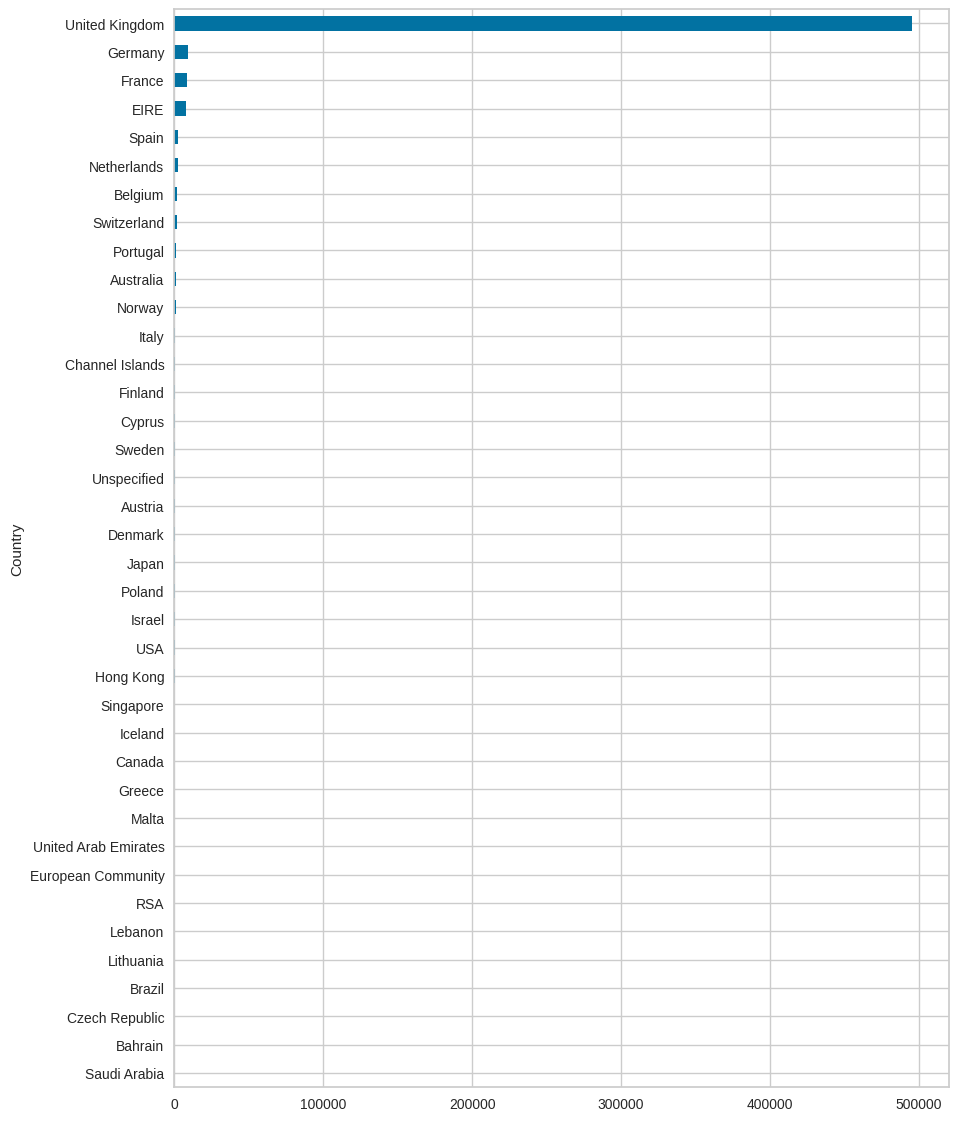

In [6]:
plt.figure(figsize=(10,14))
raw_data['Country'].value_counts(ascending=True).plot(kind='barh');

Only pick from United Kingdom

In [7]:
raw_data = raw_data.query('Country == "United Kingdom"')

Check null values inside dataset

In [ ]:
raw_data.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     133600
Country             0
dtype: int64

Remove null values

In [8]:
row_with_null = raw_data[raw_data['CustomerID'].isna()].index.tolist()
raw_data = raw_data.drop(row_with_null)

Recheck null data

In [9]:
raw_data.isna().sum()

,0
InvoiceNo,0
StockCode,0
Description,0
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,0
Country,0


In [10]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 361878 entries, 0 to 541893
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    361878 non-null  object 
 1   StockCode    361878 non-null  object 
 2   Description  361878 non-null  object 
 3   Quantity     361878 non-null  int64  
 4   InvoiceDate  361878 non-null  object 
 5   UnitPrice    361878 non-null  float64
 6   CustomerID   361878 non-null  float64
 7   Country      361878 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 24.8+ MB


Turn InvoiceDate into date type and create GMV = Quantity * Price

In [11]:
raw_data["InvoiceDate"] = pd.to_datetime(raw_data['InvoiceDate'])

In [12]:
raw_data['GMV'] = raw_data['Quantity'] * raw_data['UnitPrice']

Check time range

In [13]:
raw_data['InvoiceDate'].max()

Timestamp('2011-12-09 12:49:00')

Put maximum date as time for analysis

In [14]:
analysis_date = raw_data['InvoiceDate'].max()

Create data object for rfm modeling

In [15]:
data_for_model = raw_data.groupby(['CustomerID'], as_index=False).agg({
        'InvoiceDate': lambda x: (analysis_date - x.max()).days,
        'InvoiceNo': 'count',
        'GMV': 'sum'})

In [16]:
data_for_model.rename(columns={'InvoiceDate': 'Recency',
                         'InvoiceNo': 'Frequency',
                         'TotalSum': 'MonetaryValue'}, inplace=True)

In [17]:
data_for_model = data_for_model[data_for_model['GMV'] > 0]

Check final data for customer segmentation

In [18]:
data_for_model

,CustomerID,Recency,Frequency,GMV
1,12747.0,1,103,4196.01
2,12748.0,0,4642,29072.10
3,12749.0,3,231,3868.20
4,12820.0,2,59,942.34
5,12821.0,213,6,92.72
...,...,...,...,...
3945,18280.0,277,10,180.60
3946,18281.0,180,7,80.82
3947,18282.0,7,13,176.60
3948,18283.0,3,756,2094.88


## RFM Segmentation

Create RFM segmentation by using `rfm_table_order` function

In [19]:
r_labels = range(4, 0, -1)
f_labels = range(1, 5)
m_labels = range(1, 5)

r_groups = pd.qcut(data_for_model['Recency'], q=4, labels = r_labels)
f_groups = pd.qcut(data_for_model['Frequency'], q=4, labels = f_labels)
m_groups = pd.qcut(data_for_model['GMV'], q=4, labels = m_labels)

In [20]:
list(range(1, 5))

[1, 2, 3, 4]

In [21]:
list(range(4, 0, -1))

[4, 3, 2, 1]

In [22]:
data_for_model = data_for_model.assign(R = r_groups.values, F = f_groups.values, M = m_groups.values)

In [23]:
data_for_model['rfm_score'] = data_for_model[['R','F','M']].apply(
    lambda x: ''.join(x.astype(str)),
    axis=1
)

In [24]:
data_for_model['rfm_score'] = data_for_model['rfm_score'].astype('int')

Check final result

In [25]:
data_for_model.head()

,CustomerID,Recency,Frequency,GMV,R,F,M,rfm_score
1,12747.0,1,103,4196.01,4,4,4,444
2,12748.0,0,4642,29072.10,4,4,4,444
3,12749.0,3,231,3868.20,4,4,4,444
4,12820.0,2,59,942.34,4,3,3,433
5,12821.0,213,6,92.72,1,1,1,111


## Post-Segmentation Analysis

**Heatmap Visualization**

/tmp/ipython-input-739195628.py:2: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pd.pivot_table(data_for_model[["R", "F","GMV"]], values = "GMV", index = ["R"], columns = ["F"])


<Axes: xlabel='F', ylabel='R'>

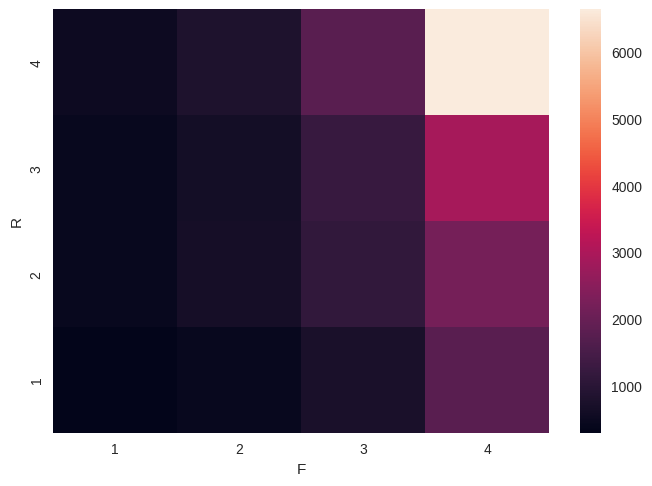

In [26]:
sns.heatmap(
    pd.pivot_table(data_for_model[["R", "F","GMV"]], values = "GMV", index = ["R"], columns = ["F"])
)

**RFM Distribution**

In [27]:
rfm_bar_data = data_for_model[["R", "F", "M"]].groupby(["R","F","M"], as_index = False).size()

/tmp/ipython-input-2666436127.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rfm_bar_data = data_for_model[["R", "F", "M"]].groupby(["R","F","M"], as_index = False).size()


/usr/local/lib/python3.12/dist-packages/seaborn/axisgrid.py:718: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


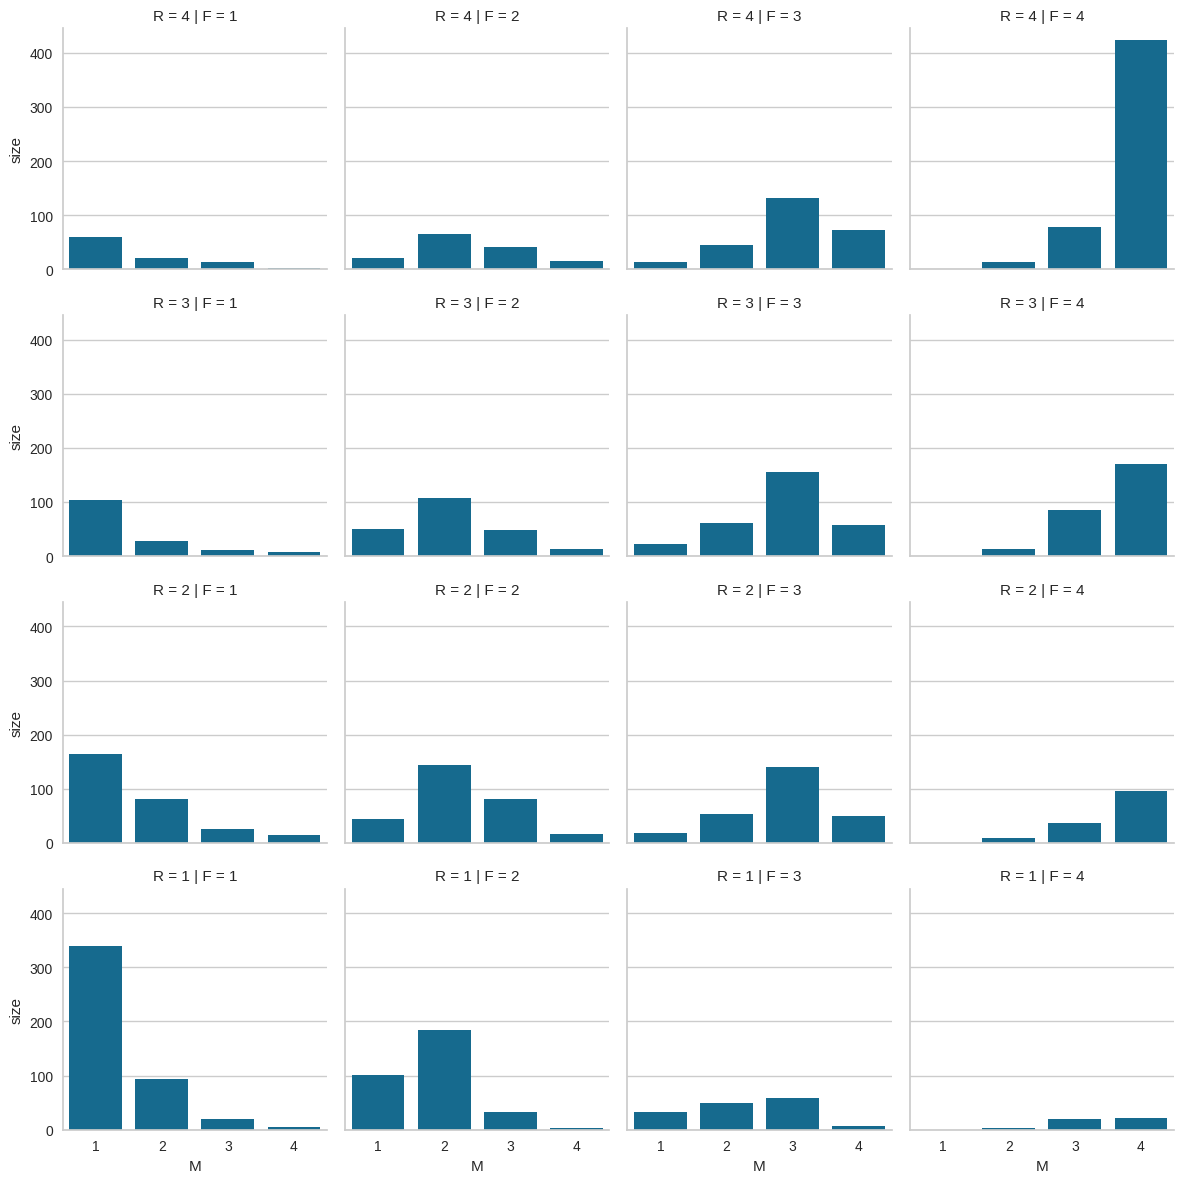

In [28]:
g = sns.FacetGrid(
    data = rfm_bar_data,
    col = "F",
    row = "R"
)
g.map(sns.barplot, "M", "size");

**Recency, Frequency, and GMV Distribution**

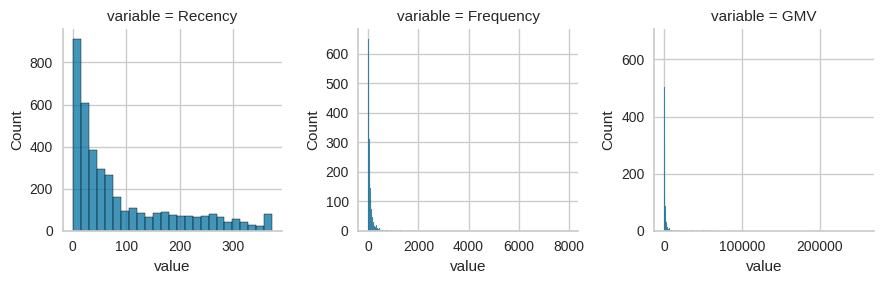

In [29]:
g = sns.FacetGrid(
    data = pd.melt(
     data_for_model[["Recency", "Frequency","GMV"]],
     value_vars=["Recency","Frequency", "GMV"]
    ),
    col = "variable",
    sharex = False,
    sharey = False
)
g.map(sns.histplot, "value");

**RFM Score to RFM Segment**

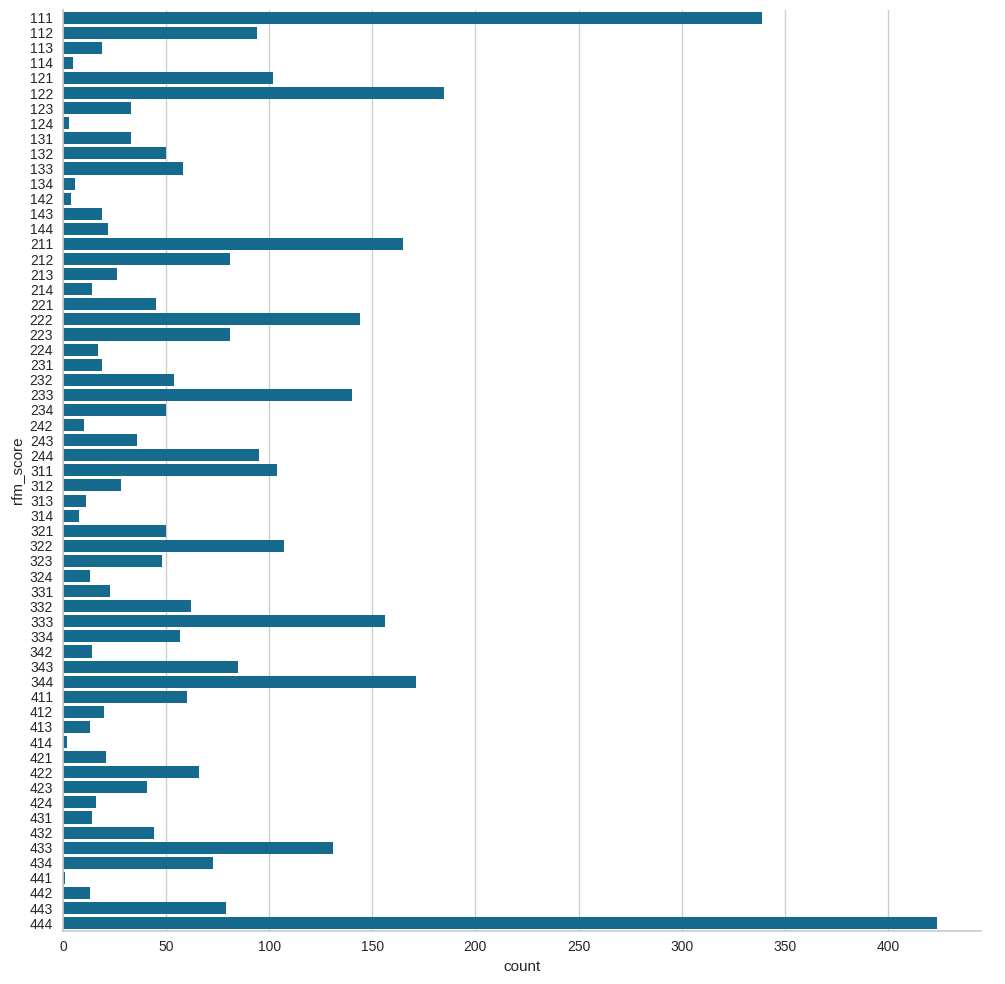

In [30]:
sns.catplot(
    y = "rfm_score",
    data = data_for_model.sort_values(by = ["rfm_score"], axis = 0),
    kind = "count",
    height = 10
)

**Segment Assignment**

## Task 1

Create cluster assignment based on recency, frequency, and monetary score and write your argument!


In [33]:
data_for_model['rfm_segment'] = np.select(
    [
        data_for_model['rfm_score'].isin([444]),
        data_for_model['rfm_score'].isin([333, 334, 343, 344, 433, 434, 443]),
        data_for_model['rfm_score'].isin([321, 322, 323, 324, 331, 332, 341, 342,
                                          412, 413, 414, 421, 422, 423, 424,
                                          431, 432, 441, 442]),
        data_for_model['rfm_score'].isin([411]),
        data_for_model['rfm_score'].isin([221, 222, 223, 224, 231, 232, 241, 242,
                                          311, 312, 313, 314]),
        data_for_model['rfm_score'].isin([133, 134, 143, 144, 233, 234, 243, 244]),
        data_for_model['rfm_score'].isin([112, 113, 114, 121, 122, 123, 124,
                                          131, 132, 141, 142, 211, 212, 213, 214]),
        data_for_model['rfm_score'].isin([111])
    ],
    [
        'Champion',
        'Loyal Customer',
        'Promising',
        'Recent Customers',
        'Customer Needing Attention',
        "Can't Lose Them",
        "At Risk",
        "Lost"
    ],
    default='Others'  # tambahkan default string biar aman
)


In [34]:
data_for_model

,CustomerID,Recency,Frequency,GMV,R,F,M,rfm_score,rfm_segment
1,12747.0,1,103,4196.01,4,4,4,444,Champion
2,12748.0,0,4642,29072.10,4,4,4,444,Champion
3,12749.0,3,231,3868.20,4,4,4,444,Champion
4,12820.0,2,59,942.34,4,3,3,433,Loyal Customer
5,12821.0,213,6,92.72,1,1,1,111,Lost
...,...,...,...,...,...,...,...,...,...
3945,18280.0,277,10,180.60,1,1,1,111,Lost
3946,18281.0,180,7,80.82,1,1,1,111,Lost
3947,18282.0,7,13,176.60,4,1,1,411,Recent Customers
3948,18283.0,3,756,2094.88,4,4,4,444,Champion


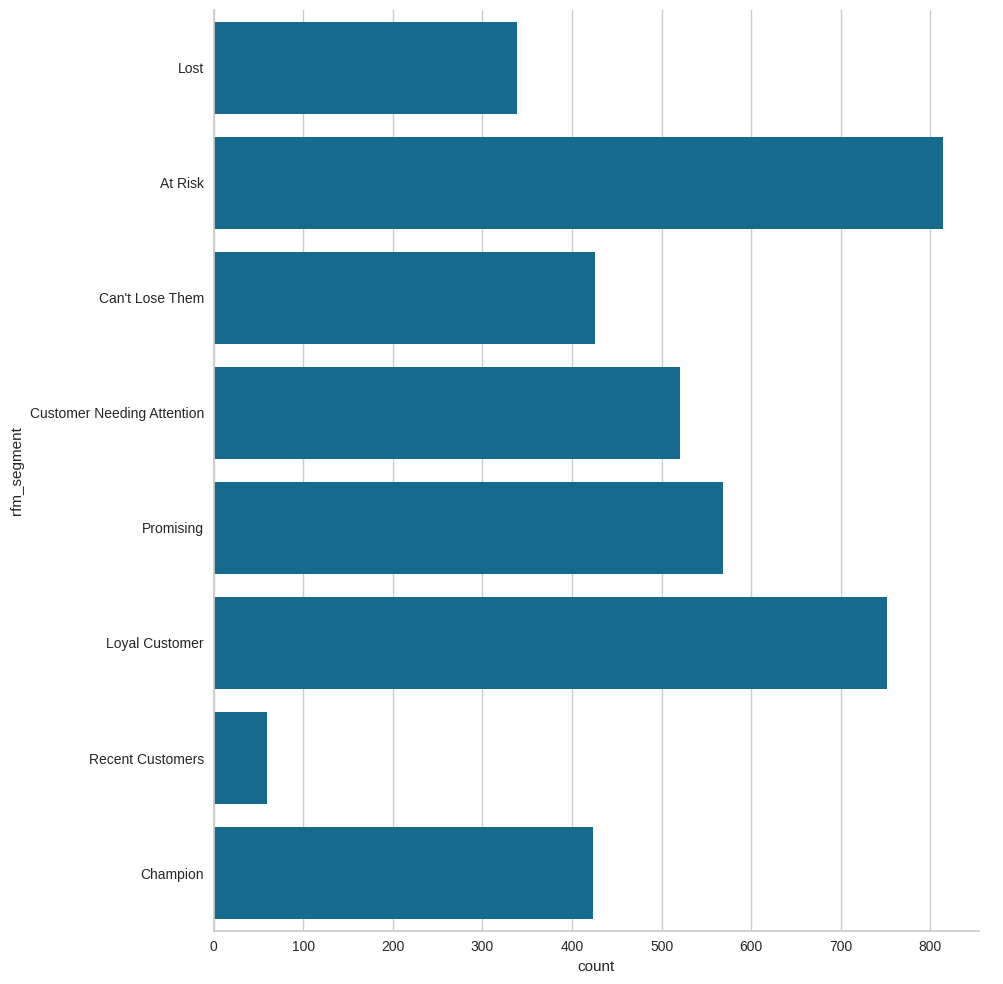

In [35]:
sns.catplot(
    y = "rfm_segment",
    data = data_for_model.sort_values(by = ["rfm_score"], axis = 0),
    kind = "count",
    height = 10
);

# K-Means Clustering

Check data for model

In [36]:
data_for_model

,CustomerID,Recency,Frequency,GMV,R,F,M,rfm_score,rfm_segment
1,12747.0,1,103,4196.01,4,4,4,444,Champion
2,12748.0,0,4642,29072.10,4,4,4,444,Champion
3,12749.0,3,231,3868.20,4,4,4,444,Champion
4,12820.0,2,59,942.34,4,3,3,433,Loyal Customer
5,12821.0,213,6,92.72,1,1,1,111,Lost
...,...,...,...,...,...,...,...,...,...
3945,18280.0,277,10,180.60,1,1,1,111,Lost
3946,18281.0,180,7,80.82,1,1,1,111,Lost
3947,18282.0,7,13,176.60,4,1,1,411,Recent Customers
3948,18283.0,3,756,2094.88,4,4,4,444,Champion


Data standarization using StandardScaler

In [37]:
scaler_obj = StandardScaler()
scaled_data = scaler_obj.fit_transform(data_for_model[["Recency", "Frequency", "GMV"]].to_numpy())
data_for_kmeans = pd.DataFrame(scaled_data, columns = ["Recency", "Frequency", "GMV"])

Check standardize data

In [38]:
data_for_kmeans

,Recency,Frequency,GMV
0,-0.893381,0.046843,0.373638
1,-0.903517,20.527130,4.152882
2,-0.873110,0.624388,0.323837
3,-0.883246,-0.151688,-0.120668
4,1.255334,-0.390828,-0.249745
...,...,...,...
3899,1.904003,-0.372780,-0.236394
3900,0.920864,-0.386316,-0.251553
3901,-0.832568,-0.359244,-0.237001
3902,-0.873110,2.993225,0.054429


## K-Means Modeling

Create clusters using k-means by setting k = 3

In [39]:
kmeans_model = KMeans(
    n_clusters = 3,
    random_state=1000
)

kmeans_model.fit(data_for_kmeans)

KMeans(n_clusters=3, random_state=1000)

Check frequencies of each cluster

In [40]:
np.unique(kmeans_model.labels_, return_counts = True)

(array([0, 1, 2], dtype=int32), array([2919,  975,   10]))

Assign cluster to "cluster" column

In [41]:
data_for_model["cluster"] = kmeans_model.labels_

## Post-Modeling Analysis

Check data after cluster assignment

In [42]:
data_for_model

,CustomerID,Recency,Frequency,GMV,R,F,M,rfm_score,rfm_segment,cluster
1,12747.0,1,103,4196.01,4,4,4,444,Champion,0
2,12748.0,0,4642,29072.10,4,4,4,444,Champion,2
3,12749.0,3,231,3868.20,4,4,4,444,Champion,0
4,12820.0,2,59,942.34,4,3,3,433,Loyal Customer,0
5,12821.0,213,6,92.72,1,1,1,111,Lost,1
...,...,...,...,...,...,...,...,...,...,...
3945,18280.0,277,10,180.60,1,1,1,111,Lost,1
3946,18281.0,180,7,80.82,1,1,1,111,Lost,1
3947,18282.0,7,13,176.60,4,1,1,411,Recent Customers,0
3948,18283.0,3,756,2094.88,4,4,4,444,Champion,0


Total users per segment

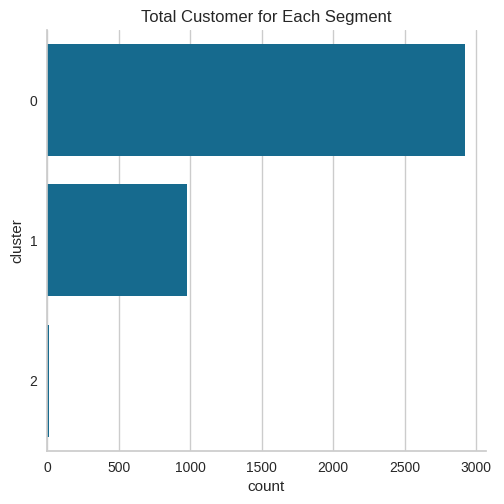

In [43]:
sns.catplot(
    y = "cluster",
    data = data_for_model,
    kind = "count",
    height = 5
).ax.set_title("Total Customer for Each Segment");

**Recency Days Distribution of Each Segment**

<Axes: xlabel='cluster', ylabel='Recency'>

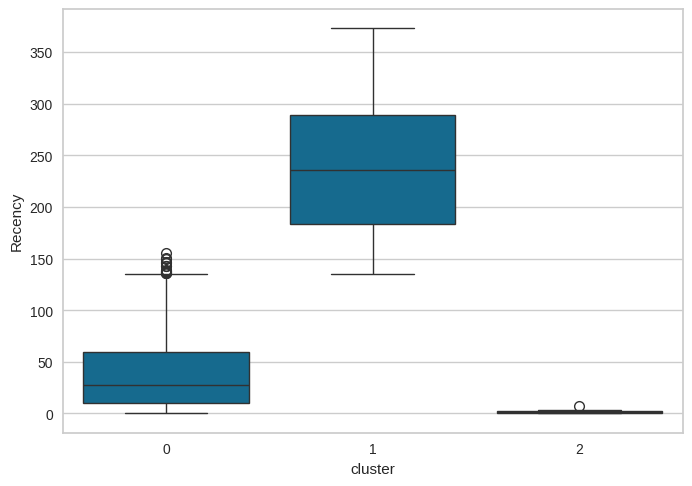

In [47]:
sns.boxplot(x = 'cluster', y = 'Recency', data = data_for_model)

**Transaction Frequency Distribution of Each Segment**

<Axes: xlabel='cluster', ylabel='Frequency'>

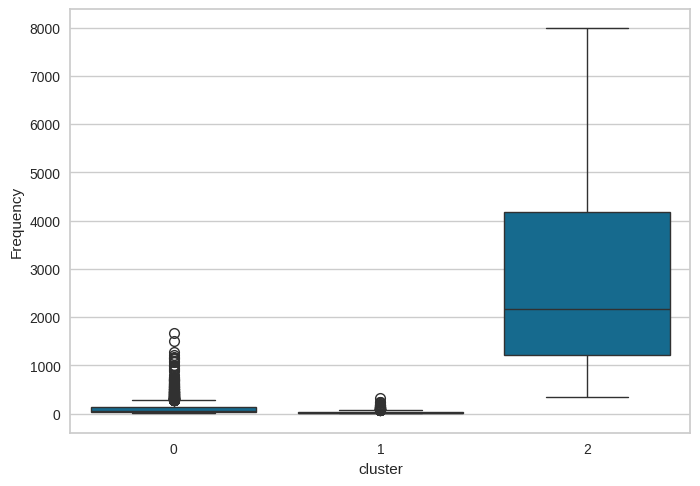

In [48]:
sns.boxplot(x = 'cluster', y = 'Frequency', data = data_for_model)

**GMV Distribution of Each Segment**

<Axes: xlabel='cluster', ylabel='GMV'>

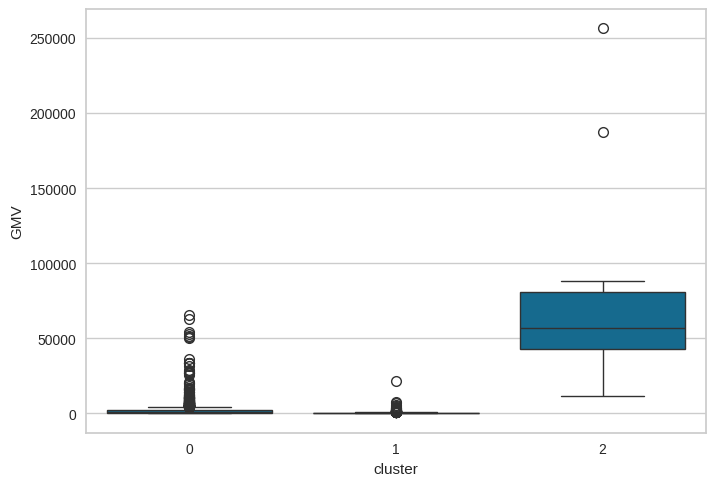

In [49]:
sns.boxplot(x = 'cluster', y = 'GMV', data = data_for_model)

## Cluster Evaluation

**Elbow Method**

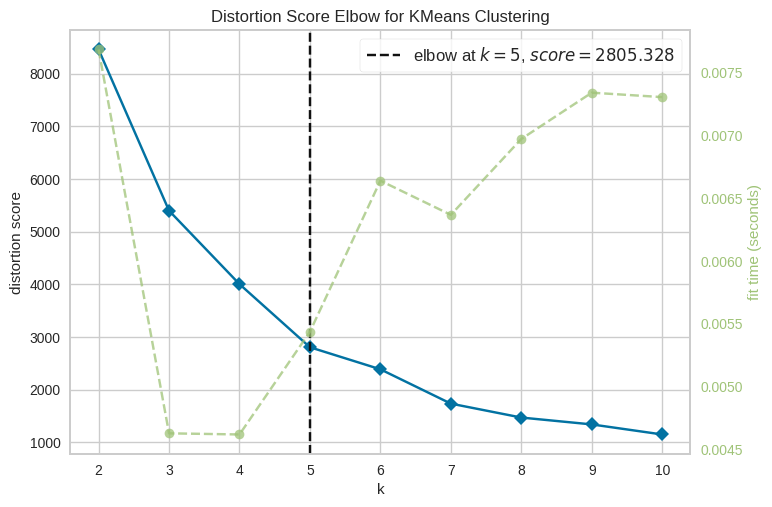

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [50]:
model = KElbowVisualizer(KMeans(random_state=1000), k=10)
model.fit(data_for_kmeans)
model.show()

**Silhouette Method**

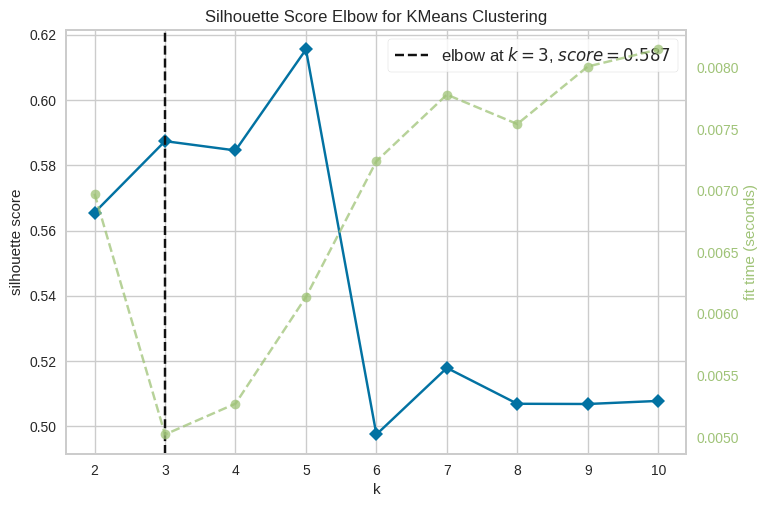

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [51]:
model = KElbowVisualizer(KMeans(random_state=1000), k=10, metric = "silhouette")
model.fit(data_for_kmeans)
model.show()

**Silhouette Visualization**

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  "X does not have valid feature names, but"


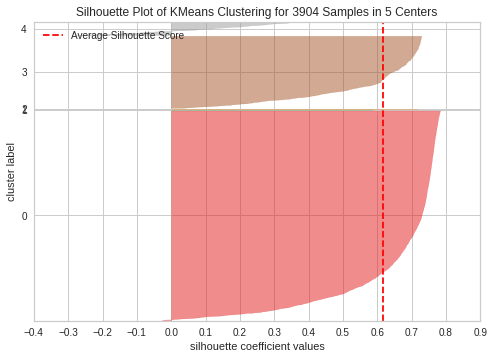

In [ ]:
visualizer = SilhouetteVisualizer(kmeans_model, is_fitted = True)
visualizer.fit(data_for_kmeans)
visualizer.show();

## Cluster Visualization

Dimensionality reduction using principal component analysis

In [ ]:
data_for_kmeans

,Recency,Frequency,GMV
0,-0.893381,0.046843,0.373638
1,-0.903517,20.527130,4.152882
2,-0.873110,0.624388,0.323837
3,-0.883246,-0.151688,-0.120668
4,1.255334,-0.390828,-0.249745
...,...,...,...
3899,1.904003,-0.372780,-0.236394
3900,0.920864,-0.386316,-0.251553
3901,-0.832568,-0.359244,-0.237001
3902,-0.873110,2.993225,0.054429


In [ ]:
pca_model = PCA()
pca_model.fit(data_for_kmeans)
pca_result = pca_model.transform(data_for_kmeans)

Check PCA result

In [ ]:
pca_model.explained_variance_ratio_

array([0.49825345, 0.29271158, 0.20903497])

In [ ]:
pca_result

array([[ 6.66330291e-01, -6.08260652e-01,  3.54898165e-01],
       [ 1.62224867e+01,  5.18018954e+00, -1.22238454e+01],
       [ 1.00001708e+00, -4.95759296e-01, -1.06020403e-01],
       ...,
       [ 2.66269681e-03, -9.05419490e-01,  2.42083361e-01],
       [ 2.36675309e+00, -1.35727411e-01, -2.02601481e+00],
       [ 1.61366658e-01, -4.32108784e-01,  1.61899342e-01]])

Visualize cluster

In [ ]:
pca_result = pd.DataFrame(pca_result, columns = ["PC1", "PC2", "PC3"])
pca_result['cluster'] = kmeans_model.labels_

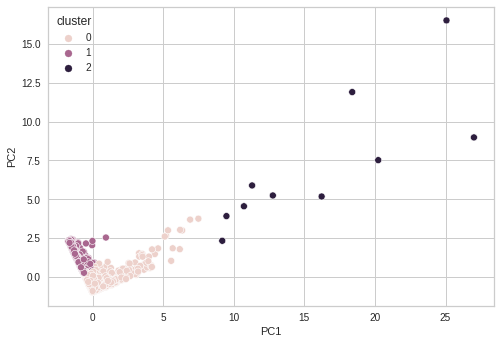

In [ ]:
sns.scatterplot(data = pca_result, x = "PC1", y = "PC2", hue = "cluster");

Visualization by using convex hull

In [ ]:
centroids = kmeans_model.cluster_centers_
cen_x = [i[0] for i in centroids]
cen_y = [i[1] for i in centroids]
colors = ['#DF2020', '#81DF20', '#2095DF']
pca_result['c'] = pca_result.cluster.map({0:colors[0], 1:colors[1], 2:colors[2]})

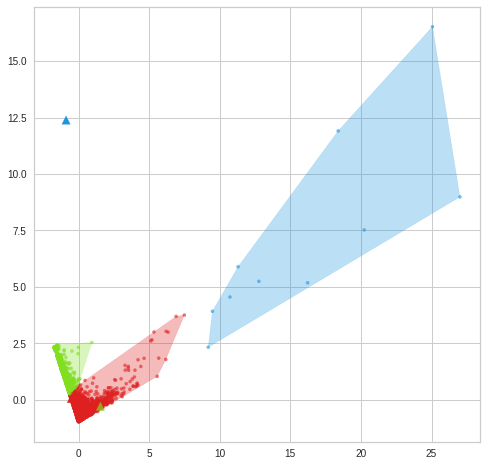

In [ ]:
fig, ax = plt.subplots(1, figsize=(8,8))

plt.scatter(pca_result.PC1, pca_result.PC2, c=pca_result.c, alpha = 0.6, s=10)
plt.scatter(cen_x, cen_y, marker='^', c=colors, s=70)

# draw enclosure
for i in pca_result.cluster.unique():
    points = pca_result[pca_result.cluster == i][['PC1', 'PC2']].values
    hull = ConvexHull(points)
    x_hull = np.append(points[hull.vertices,0],
                       points[hull.vertices,0][0])
    y_hull = np.append(points[hull.vertices,1],
                       points[hull.vertices,1][0])
    plt.fill(x_hull, y_hull, alpha=0.3, c=colors[i])

## Biplot

In [ ]:
def myplot(score, coeff, labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.scatter(xs * scalex,ys * scaley)
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))
    plt.grid()

In [ ]:
pca_model = PCA()
pca_model.fit(data_for_kmeans)
pca_result = pca_model.transform(data_for_kmeans)

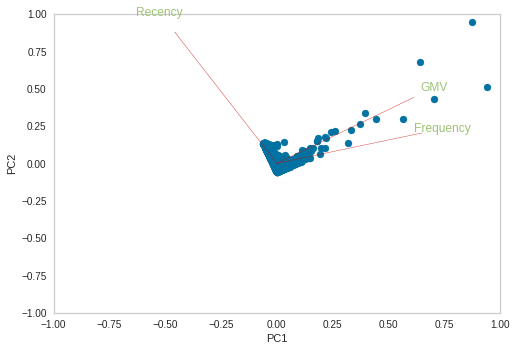

In [ ]:
myplot(pca_result[:,0:3], np.transpose(pca_model.components_[0:3, :]), labels = ["Recency", "Frequency", "GMV"])
plt.show()

In [ ]:
pca_result[:,0:3]

array([[ 6.66330291e-01, -6.08260652e-01,  3.54898165e-01],
       [ 1.62224867e+01,  5.18018954e+00, -1.22238454e+01],
       [ 1.00001708e+00, -4.95759296e-01, -1.06020403e-01],
       ...,
       [ 2.66269681e-03, -9.05419490e-01,  2.42083361e-01],
       [ 2.36675309e+00, -1.35727411e-01, -2.02601481e+00],
       [ 1.61366658e-01, -4.32108784e-01,  1.61899342e-01]])

In [ ]:
pca_model.components_[0:2, :]

array([[-0.45622036,  0.64650707,  0.61146675],
       [ 0.87524845,  0.20196955,  0.43948657]])

## Task 2

We know that from elbow method, silhouette method, and gap statistics 3 is not the best cluster. Rebuild k-means model, evaluate, and interprete the result based on the new result you build. Just pick one k to be analyze, doesn't need to analyze all of the possibilities.
